 # Structure Factor GPU Testing & Debugging



 This notebook tests and debugs the GPU-accelerated structure factor calculator.

# Create Test Data

Created test_particles_100.csv: (100, 2)
Created test_particles_1000.csv: (1000, 2)
Created test_grid_6x6.csv: (36, 2)


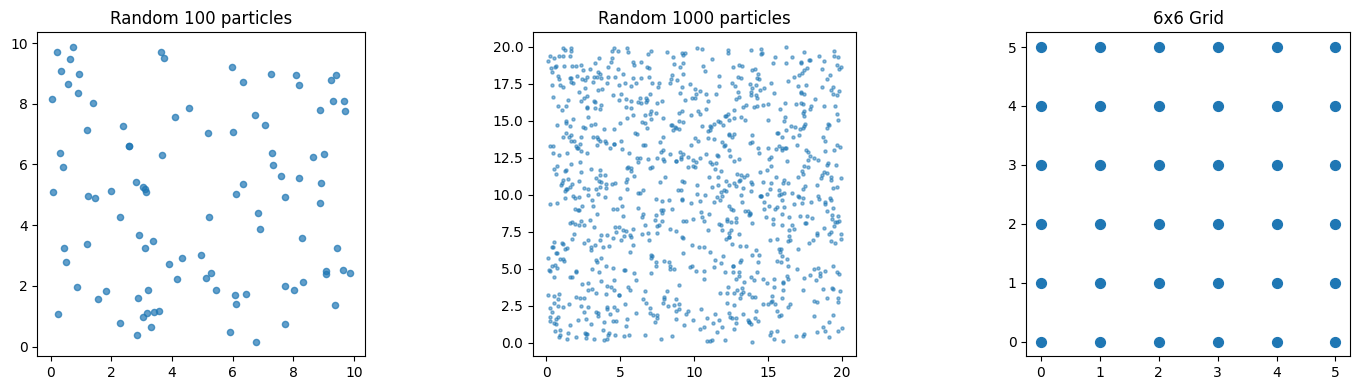

In [2]:
# Create simple test datasets
def create_test_data():
    """Create simple test particle arrangements."""
    
    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)
    os.makedirs('results', exist_ok=True)
    
    # Test 1: Small random arrangement (100 particles)
    np.random.seed(42)
    particles_100 = np.random.rand(100, 2) * 10  # 10x10 area
    np.savetxt('data/test_particles_100.csv', particles_100, delimiter=',')
    print(f"Created test_particles_100.csv: {particles_100.shape}")
    
    # Test 2: Medium random arrangement (1000 particles)
    particles_1000 = np.random.rand(1000, 2) * 20  # 20x20 area
    np.savetxt('data/test_particles_1000.csv', particles_1000, delimiter=',')
    print(f"Created test_particles_1000.csv: {particles_1000.shape}")
    
    # Test 3: Simple grid for validation
    x = np.linspace(0, 5, 6)
    y = np.linspace(0, 5, 6)
    xx, yy = np.meshgrid(x, y)
    grid_particles = np.column_stack([xx.ravel(), yy.ravel()])
    np.savetxt('data/test_grid_6x6.csv', grid_particles, delimiter=',')
    print(f"Created test_grid_6x6.csv: {grid_particles.shape}")
    
    return particles_100, particles_1000, grid_particles

# Create test data
particles_100, particles_1000, grid_particles = create_test_data()

# Visualize test data
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(particles_100[:, 0], particles_100[:, 1], s=20, alpha=0.7)
axes[0].set_title('Random 100 particles')
axes[0].set_aspect('equal')

axes[1].scatter(particles_1000[:, 0], particles_1000[:, 1], s=5, alpha=0.5)
axes[1].set_title('Random 1000 particles')
axes[1].set_aspect('equal')

axes[2].scatter(grid_particles[:, 0], grid_particles[:, 1], s=50)
axes[2].set_title('6x6 Grid')
axes[2].set_aspect('equal')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd

# target points
n_points = 1000

# find grid size just above n_points
side = int(np.ceil(np.sqrt(n_points)))
x = np.linspace(0, 1, side, endpoint=False)
y = np.linspace(0, 1, side, endpoint=False)

# generate full grid
X, Y = np.meshgrid(x, y)
points = np.column_stack((X.ravel(), Y.ravel()))

# save as CSV (two columns: x, y)
df = pd.DataFrame(points, columns=['x', 'y'])
df.to_csv('./data/test_particles_1024.csv', index=False, header=False)

print(f"Saved {len(points)} points in a {side}×{side} grid (trimmed to {n_points})")

Saved 1024 points in a 32×32 grid (trimmed to 1000)


# Test Calculator Class

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os

# Add parent directory to path so we can import our module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Import our classes
from structure_factor import StructureFactorCalculator_cpu, StructureFactorVisualizer

calculator = StructureFactorCalculator_cpu(memory_fraction=0.8)
calculator.calculate_structure_factor_and_save(
    read_folder='./data/',
    filename='test_grid_31x31',
    range_calculation=5.0,
    vector_step=0.1,
    save_folder='./results/',
    save_dat=False,
    full_plane=True
)

2025-08-12 00:02:18,725 - INFO - Processing file: test_grid_31x31
2025-08-12 00:02:18,735 - INFO - Structure analysis: 961 particles, avg neighbor distance: 0.666666
2025-08-12 00:02:18,747 - INFO - Selected structure factor calculation method: matrix_by_parts
2025-08-12 00:02:18,748 - INFO - q-range: -7500005.50 µm⁻¹ to 7350004.00 µm⁻¹
2025-08-12 00:02:18,931 - INFO - Matrix-by-parts configuration: d_length=923521, q_length=100, max_rows_per_chunk=37
2025-08-12 00:02:18,932 - INFO - Processing chunk 1: rows=37 (indices 0:37), cols=923521


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
import os

# Add parent directory to path so we can import our module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

# Import our classes
from handler_cpu_gpu import compute_structure_factor_auto

compute_structure_factor_auto(
    read_folder='./data/',
    filename='test_grid_31x31',
    range_calculation=10.0,
    vector_step=0.05,
    save_folder='./results/',
    save_dat=False,
    full_plane=True,
    memory_fraction=0.7,
    backend="auto"
)

2025-08-12 00:27:30,448 - INFO - PyTorch version: 2.8.0+cu126
2025-08-12 00:27:30,448 - INFO - CUDA available: True
2025-08-12 00:27:30,448 - INFO - CUDA available: NVIDIA GeForce RTX 3060
2025-08-12 00:27:30,449 - INFO - GPU Memory: 12.9 GB
2025-08-12 00:27:30,450 - INFO - GPU available: NVIDIA GeForce RTX 3060
2025-08-12 00:27:30,450 - INFO - Processing file: test_grid_31x31
2025-08-12 00:27:30,463 - INFO - Q-range: tensor(-15000000., device='cuda:0') to tensor(14924999., device='cuda:0') (physical units)
2025-08-12 00:27:31,189 - INFO - Progress: 0.0% (0/400)
2025-08-12 00:27:31,575 - INFO - Progress: 0.2% (1/400)
2025-08-12 00:27:31,962 - INFO - Progress: 0.5% (2/400)
2025-08-12 00:27:32,351 - INFO - Progress: 0.8% (3/400)
2025-08-12 00:27:32,737 - INFO - Progress: 1.0% (4/400)
2025-08-12 00:27:33,125 - INFO - Progress: 1.2% (5/400)
2025-08-12 00:27:33,512 - INFO - Progress: 1.5% (6/400)
2025-08-12 00:27:33,899 - INFO - Progress: 1.8% (7/400)
2025-08-12 00:27:34,290 - INFO - Progre

# Test Visualizer Class

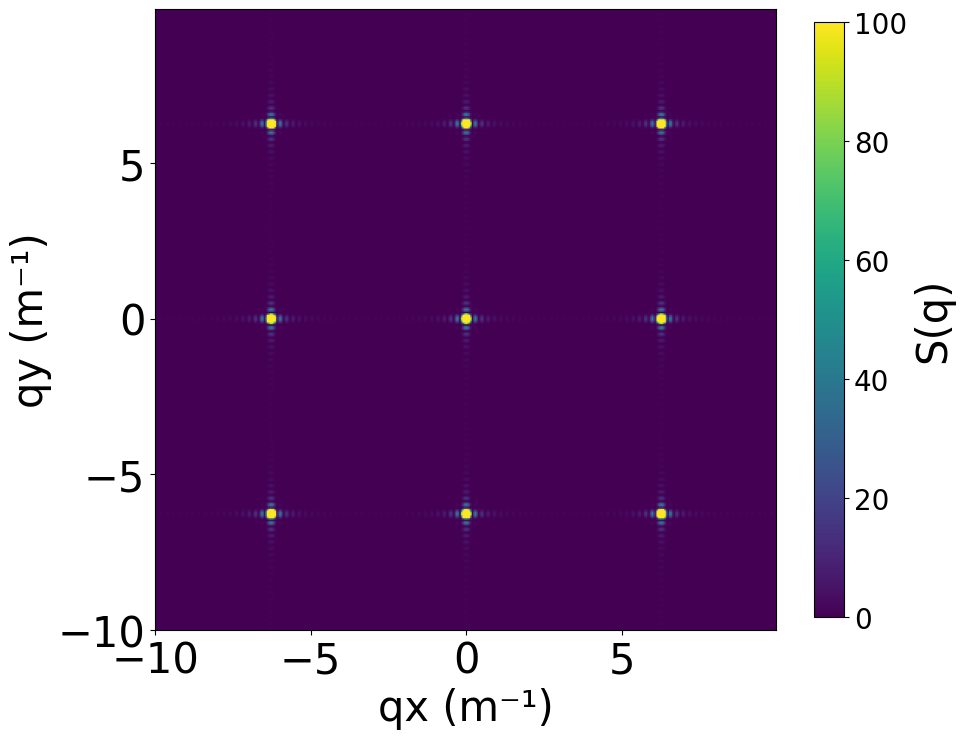

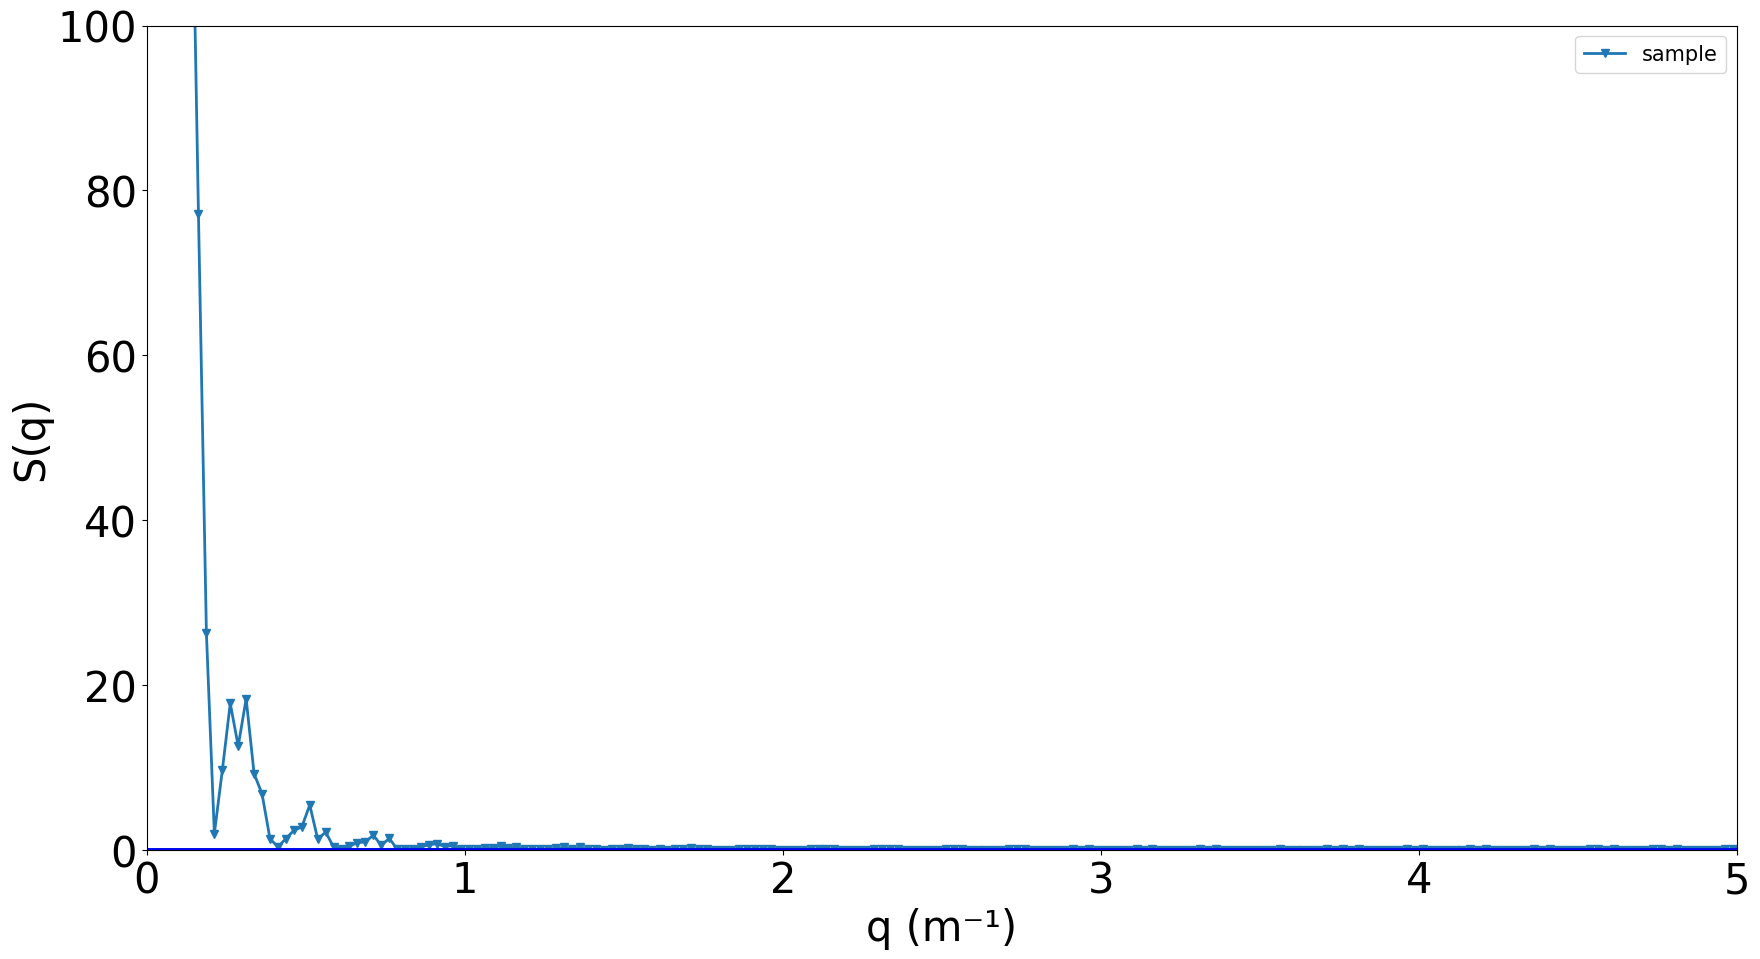

In [5]:
import sys
import os

# Add parent directory to path so we can import our module
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import os, glob, logging
from structure_factor import StructureFactorVisualizer

# show INFO logs from the computation/plot pipeline (optional)
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

data_folder = './results'            # where save_data wrote the .h5
prefix = 'sq2d-test_particles_1000-' # new filename style prefix
pattern = os.path.join(data_folder, f'{prefix}*.h5')

# grab the most recent file
latest_h5 = max(glob.glob(pattern), key=os.path.getmtime)
base = "sq2d-test_grid_31x31-qD-10.000-9.950-dq0.050-t20250811T223010Z"  # strip .h5

# ensure output folder exists
os.makedirs('./figures', exist_ok=True)

visualizer = StructureFactorVisualizer()

# 2D with nicer contrast and viridis
visualizer.plot_Sq_2D(
    data_folder='./results',
    filename=base,                 # HDF5 base name (no extension)
    edge=(-100, 100),
    x_axis='qD',
    auto_contrast=True,
    cmap='viridis',
    vmax = 100,
    save_plot=True,
    folder_write='./figures'
)

# 1D, smooth a bit, don't show (grab fig/ax)
fig, ax = visualizer.plot_Sq_1D(
    data_folder='./results',
    filename=[base],
    labels=['sample'],
    edges=(0, 5),
    moving_average=False,
    auto_ylim = False,
    show=True
)

In [ ]:
visualizer.plot_Sq_1D(
            data_folder='./output',
            filename='test_particles_1000_range_9_step_0.3_20250807T192923',
            plot_range=(0,9),
            coordinate_system='qD',
            save_plot=True,
            output_folder='./figures'
        )

AttributeError: 'StructureFactorVisualizer' object has no attribute 'plot_1d_structure_factor'

# Performance Comparison (CPU vs GPU)

In [ ]:
import time

def benchmark_calculation(n_particles, q_points, use_gpu=True):
    """Simple benchmark of calculation speed."""
    
    # Create test data
    test_data = np.random.rand(n_particles, 2) * 10
    np.savetxt('data/benchmark_test.csv', test_data, delimiter=',')
    
    # Calculate parameters
    D, N = calculator.get_calculation_parameters(test_data)
    
    # Generate vectors
    structure_tensor = torch.from_numpy(test_data)
    d_x, d_y, q = calculator.generate_vectors(structure_tensor, 5.0, 5.0/q_points, D)
    
    # Move to appropriate device
    device = 'cuda' if (use_gpu and torch.cuda.is_available()) else 'cpu'
    d_x = d_x.to(device)
    d_y = d_y.to(device)
    q = q.to(device)
    N_tensor = torch.tensor(N, dtype=torch.float).to(device)
    
    print(f"Benchmarking {n_particles} particles, {len(q)} q-points on {device}")
    
    # Time the calculation (just a few q-points for speed)
    start_time = time.time()
    
    # Calculate just a small portion for timing
    n_test = min(3, len(q))  # Test first 3x3 q-points
    structure_factor = torch.zeros((n_test, n_test), device=device)
    
    for a in range(n_test):
        for b in range(n_test):
            structure_factor[a,b] = (1/N_tensor)*torch.sum(torch.exp(1j*(q[a]*d_x + q[b]*d_y)))
    
    end_time = time.time()
    calculation_time = end_time - start_time
    
    # Extrapolate to full calculation
    full_time_estimate = calculation_time * (len(q)/n_test)**2
    
    print(f"  Partial calculation time: {calculation_time:.3f} seconds")
    print(f"  Full calculation estimate: {full_time_estimate:.1f} seconds")
    
    return calculation_time, full_time_estimate

# Run benchmarks
print("Performance Benchmarking:")
print("=" * 50)

# Small test
cpu_time, cpu_full = benchmark_calculation(100, 10, use_gpu=False)
if torch.cuda.is_available():
    gpu_time, gpu_full = benchmark_calculation(100, 10, use_gpu=True)
    speedup = cpu_time / gpu_time
    print(f"  Speedup: {speedup:.1f}x")
else:
    print("  GPU not available for comparison")
